# Wprowadzenie
W tym zadaniu będziemy trenować algorytm **QSVC (Quantum Support Vector Classifier)** z wykorzystaniem **Pauli Feature Map**, czyli innego kwantowego odwzorowania cech. Pauli Feature Map to odwzorowanie kwantowe, które stosuje bramki kwantowe Pauli do przekształcania danych klasycznych do przestrzeni kwantowej.

Documentation to QSVC: 

https://qiskit-community.github.io/qiskit-machine-learning/tutorials/03_quantum_kernel.html

https://qiskit-community.github.io/qiskit-machine-learning/stubs/qiskit_machine_learning.algorithms.QSVC.html

## Zadanie 1: Przygotowanie danych
Najpierw przygotujemy dane, które będziemy klasyfikować. Korzystamy z zestawu danych "księżyce", który generuje dwa zbiory punktów klasyfikacyjnych o nieregularnym kształcie.

**Zadanie: Wygenerujcie dane i wyświetlcie je na wykresie**

In [1]:
from qiskit_algorithms.utils import algorithm_globals

random_seed = 1234 # setting randomness seed 
algorithm_globals.random_seed = random_seed

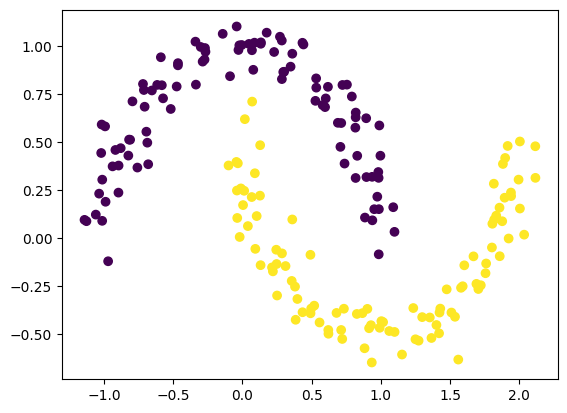

In [2]:
%matplotlib inline

from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

X, y = make_moons(n_samples=200, noise=.08, random_state=random_seed)

import matplotlib.pyplot as plt 

plt.scatter(X[:,0], X[:,1], c=y)

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=random_seed)
X.shape, X_train.shape, X_test.shape

((200, 2), (160, 2), (40, 2))

## Zadanie 2: Quantum Feature Map
Teraz stworzymy Pauli Feature Map, czyli kwantową mapę cech. Użycie takiej mapy pozwala na przekształcenie danych klasycznych w przestrzeń kwantową, w której algorytmy kwantowe mogą skutecznie działać.

**Zadanie: Utwórzcie Pauli Feature Map i obliczcie macierz jądra dla danych treningowych i testowych.**

Documentation for Pauli Feature Map: https://docs.quantum.ibm.com/api/qiskit/qiskit.circuit.library.PauliFeatureMap

Documentation for FidelityQuantumKernel: https://qiskit-community.github.io/qiskit-machine-learning/stubs/qiskit_machine_learning.kernels.FidelityQuantumKernel.html

In [4]:
from qiskit.circuit.library import PauliFeatureMap
from qiskit.primitives import Sampler
from qiskit_algorithms.state_fidelities import ComputeUncompute
from qiskit_machine_learning.kernels import FidelityQuantumKernel

feature_dimension = len(X[0])

# TODO: Stwórzcie Pauli Feature Map
dataset_feature_map = PauliFeatureMap(
    feature_dimension=feature_dimension, 
    reps=2, 
    entanglement='full', 
    paulis=None, 
    data_map_func=None, 
    parameter_prefix='x', 
    insert_barriers=False
)

# TODO: zainicjalizowac sampler
sampler = Sampler()

# TODO: stowrzyc fidelity
fidelity=ComputeUncompute(sampler=sampler)

# TODO: Utwórzcie kwantowe jądro
quantum_kernel=FidelityQuantumKernel(fidelity=fidelity, feature_map=dataset_feature_map) # definiowanie jądra kwantowego

C:\Users\jozek\AppData\Local\Temp\ipykernel_9668\1864440856.py:20: DeprecationWarning: The class ``qiskit.primitives.sampler.Sampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Sampler` class is `StatevectorSampler`.
  sampler = Sampler()


## Obliczanie macierzy jądra dla zbioru treningowego i testowego i wizualizacja


In [5]:
import matplotlib.pyplot as plt
import numpy as np

moon_matrix_train = quantum_kernel.evaluate(x_vec=X_train)
moon_matrix_test = quantum_kernel.evaluate(x_vec=X_test, y_vec=X_train)

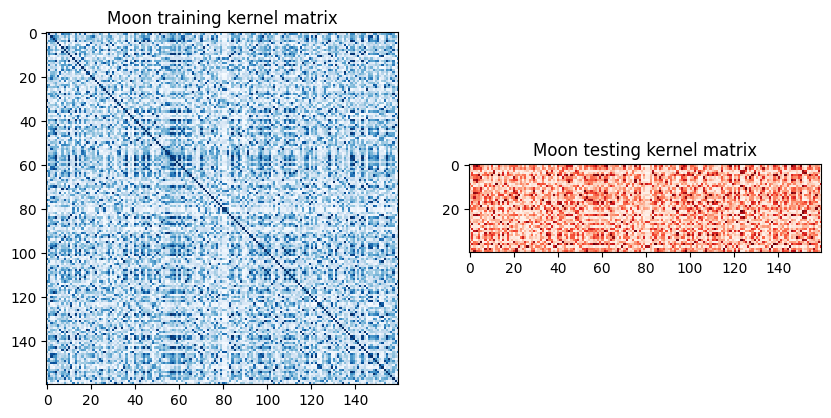

In [6]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].imshow(
    np.asmatrix(moon_matrix_train), interpolation="nearest", origin="upper", cmap="Blues"
)
axs[0].set_title("Moon training kernel matrix")

axs[1].imshow(np.asmatrix(moon_matrix_test), interpolation="nearest", origin="upper", cmap="Reds")
axs[1].set_title("Moon testing kernel matrix")
plt.show()

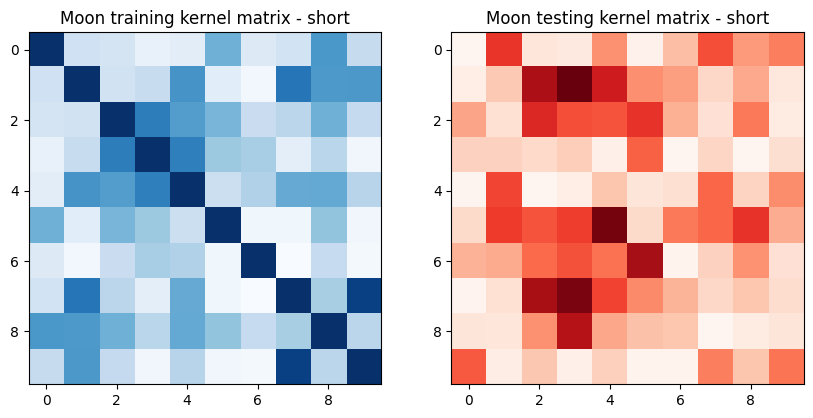

In [7]:
moon_matrix_short = quantum_kernel.evaluate(x_vec=X_train[:10])
moon_matrix_test_short = quantum_kernel.evaluate(x_vec=X_test[:10], y_vec=X_train[:10])

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].imshow(
    np.asmatrix(moon_matrix_short), interpolation="nearest", origin="upper", cmap="Blues"
)
axs[0].set_title("Moon training kernel matrix - short")

axs[1].imshow(np.asmatrix(moon_matrix_test_short), interpolation="nearest", origin="upper", cmap="Reds")
axs[1].set_title("Moon testing kernel matrix - short")
plt.show()

## Zadanie 3: Trening modelu SVM z prekomputowaną macierzą jądra
Podobnie jak wcześniej, wytrenujemy klasyczny model SVM, ale zamiast klasycznych funkcji jądra, użyjemy macierzy jądra uzyskanej za pomocą kwantowej mapy cech.

**Zadanie: Wytrenujcie model SVM z prekomputowaną macierzą jądra i oceńcie jego dokładność.**

In [8]:

from sklearn.svm import SVC

moon_svc = SVC(kernel='precomputed')
moon_svc.fit(moon_matrix_train, y_train)
moon_score_precomputed_kernel = moon_svc.score(moon_matrix_test, y_test)

print(f"Precomputed kernel classification test score: {moon_score_precomputed_kernel*100}%")

Precomputed kernel classification test score: 72.5%


## Zadanie 4: Trening modelu QSVC
Teraz możemy wytrenować model QSVC z użyciem Pauli Feature Map i ocenić, jak dobrze działa w porównaniu z klasycznym SVM.

**Zadanie: Wytrenujcie model QSVC i oceńcie jego dokładność.**

In [9]:
%%time
from qiskit_machine_learning.algorithms import QSVC

qsvc = QSVC(quantum_kernel=quantum_kernel)
qsvc.fit(X_train, y_train)
qsvc_score = qsvc.score(X_test, y_test)

print(f"QSVC classification test score: {qsvc_score*100}%")

QSVC classification test score: 72.5%
CPU times: total: 28 s
Wall time: 2min 20s


## Zadanie 5: Wizualizacja granic decyzyjnych
Ostatni krok to wizualizacja granic decyzyjnych uzyskanych przez model QSVC. W ten sposób zobaczycie, jak algorytm dzieli przestrzeń cech na różne klasy.

**Zadanie: Wizualizujcie granice decyzyjne modelu QSVC.**


P.S uruchomenie kolorowej wizualizacji moze trwac do kilkadiesiecu minut

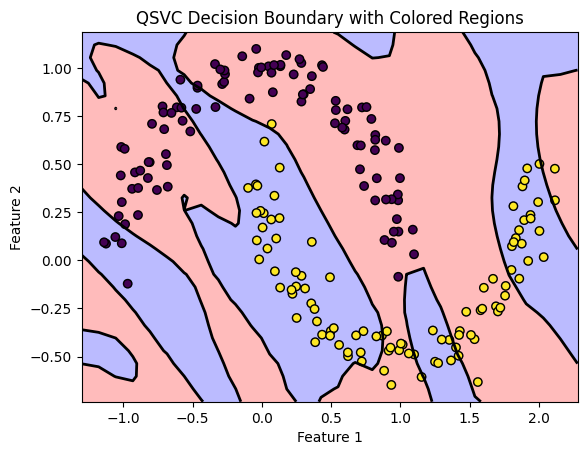

CPU times: total: 14min 9s
Wall time: 36min 48s


In [11]:
%%time
plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k', marker='o')
# Plotting decision boundaries
plt.title('QSVC Decision Boundary with Colored Regions')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')

# Create a grid
ax = plt.gca()
xlim = ax.get_xlim()
ylim = ax.get_ylim()

# Plot the colored areas
xx = np.linspace(xlim[0], xlim[1], 30)
yy = np.linspace(ylim[0], ylim[1], 30)
YY, XX = np.meshgrid(yy, xx)
xy = np.vstack([XX.ravel(), YY.ravel()]).T
Z = qsvc.decision_function(xy).reshape(XX.shape)

ax.contourf(XX, YY, Z, levels=[Z.min(), 0, Z.max()], colors=['#FFAAAA', '#AAAAFF'], alpha=0.8)
ax.contour(XX, YY, Z, colors='k', levels=[0], linewidths=2)
plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k', marker='o')
plt.title('QSVC Decision Boundary with Colored Regions')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()

## Podsumowanie:

W tym zadaniu nauczyliście się, jak używać Pauli Feature Map z QSVC.

Porównaliście wyniki klasycznego SVM z kwantowym QSVC.

Wizualizowaliście granice decyzyjne, aby zobaczyć, jak algorytmy dzielą przestrzeń cech na różne klasy.